### Analysing subreddit data using NLP

We will be analysing a reddit community, known as a `subreddit`. For this project, we have chosen [r/geopolitics](https://www.reddit.com/r/geopolitics/) and will perform different analysis techniques on the data scraped from it. The following libraries are majorly used in this project:
- `nltk`: Utilities for natural language processing
- `praw`: Scraping subreddit and user data
- `pandas`: Creating and modifying dataframes

In [2]:
import praw
from dotenv import dotenv_values

config = dotenv_values(".env")

reddit = praw.Reddit(
    client_id=config["CLIENT_ID"],
    client_secret=config["CLIENT_SECRET"],
    user_agent=config["USER_AGENT"],
)

In [3]:
import re

from nrclex import NRCLex

def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def analyze_emotion(text: str) -> str:
    lexicon = NRCLex(clean_text(text))
    emotions = lexicon.affect_frequencies
    dominant_emotion = max(emotions, key=emotions.get)
    return dominant_emotion

In [34]:
from datetime import datetime

subreddit = reddit.subreddit("worldnews")
submissions = []

for post in subreddit.top(time_filter="month", limit=None):
    submissions.append([
        post.title,
        post.num_comments,
        datetime.utcfromtimestamp(post.created_utc).strftime("%Y-%m-%d"),
        post.author,
        post.score,
        post.upvote_ratio,
        post.num_crossposts,
        analyze_emotion(post.title),
    ])

In [35]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

for post in submissions:
    score = analyzer.polarity_scores(clean_text(post[0]))
    post.append(score["compound"])

In [67]:
import pandas as pd

df = pd.DataFrame(
    submissions,
    columns=["title", "comments", "created", "author", "upvotes", "upvote_ratio", "crossposts", "emotion", "compound"],
)

df["sentiment"] = 0
df.loc[df["compound"] > 0.20, "sentiment"] = 1
df.loc[df["compound"] < -0.20, "sentiment"] = -1

In [68]:
df.drop("compound", axis=1, inplace=True)
df

,title,comments,created,author,upvotes,upvote_ratio,crossposts,emotion,sentiment
0,Senior US lawmaker confirms Egypt warned Israe...,3794,2023-10-11,AmatuerNetworkist,34788,0.93,10,fear,-1
1,Israel resumes water supply to southern Gaza a...,5270,2023-10-15,HappyBavarian,33064,0.91,4,positive,-1
2,Residents near Gaza border beg for help: 'They...,9314,2023-10-07,Mazcal,30548,0.87,9,negative,0
3,Israel says no humanitarian break to Gaza sieg...,13604,2023-10-12,project_95,29983,0.89,7,surprise,0
4,Hamas official promises: 'We'll repeat Oct. 7 ...,7416,2023-11-01,BinaryPhinary2,28309,0.78,13,fear,1
...,...,...,...,...,...,...,...,...,...
994,Russian foreign minister thanks North Korea fo...,31,2023-10-19,Takagixu,447,0.91,1,negative,1
995,Likud Minister Formulates Emergency Regulation...,102,2023-10-15,AlyoshaV,444,0.88,1,negative,-1
996,Drought in Brazil's Amazon sparks fears for th...,14,2023-10-09,giuliomagnifico,444,0.93,0,trust,-1
997,Ghana plunged into darkness as country faces e...,49,2023-10-30,Relevant_Ninja2251,438,0.96,1,fear,-1


<Axes: title={'center': 'Distribution of emotions on r/Geopolitics'}, xlabel='Emotion', ylabel='Posts Count'>

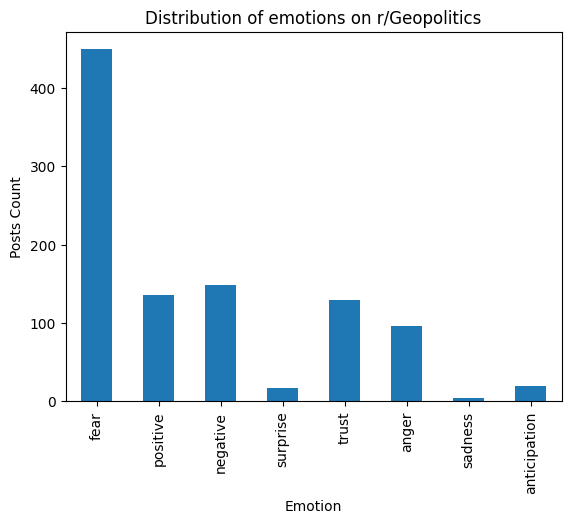

In [71]:
emotion_count = df.emotion.value_counts(sort=False)
emotion_count.plot.bar(xlabel="Emotion", ylabel="Posts Count", title="Distribution of emotions on r/Geopolitics")

<Axes: title={'center': 'Distribution of sentiments on r/Geopolitics'}, xlabel='Sentiment', ylabel='Posts Count'>

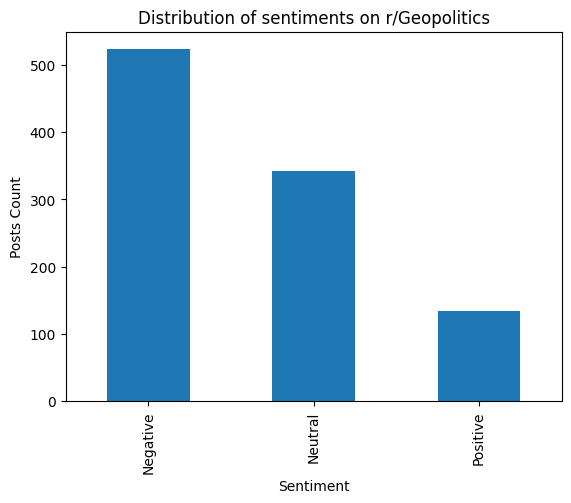

In [45]:
sentiment_count = df.sentiment.value_counts()
sentiment_count.index = ["Negative", "Neutral", "Positive"]
sentiment_count.plot.bar(xlabel="Sentiment", ylabel="Posts Count", title="Distribution of sentiments on r/Geopolitics")

<Axes: title={'center': 'Posting frequency on r/Geopolitics'}, xlabel='Date Created', ylabel='Posts Count'>

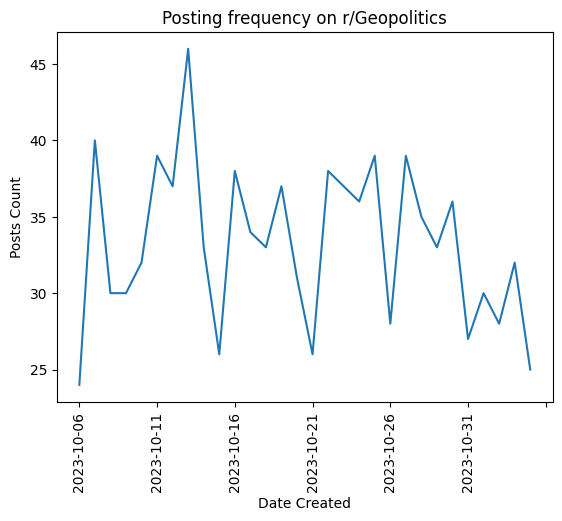

In [80]:
created_count = df.created.value_counts().sort_index()
created_count.plot.line(xlabel="Date Created", ylabel="Posts Count", title="Posting frequency on r/Geopolitics", rot=90)